<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/banner_SA.jpg" alt="Drawing" style="width:1000px;">


# <center> 14. SIMULATED ANNEALING (SA) </center>


### simulated annealing + template (recocido + templado)

As **GAs** the **SA** is an algorithm to solve **global** optimization problems. 

- The **main goal** is to find a **good** approximation of an optimization problem, within a very large space solution, typically **NP**

## <span style="color:red"> Outline </span> 
1. **SA: From metallurgy to computation**
2. **SA: The Traveling Salesman Problem**
3. **SA: initialization and heating**
4. **SA: Assembling, cooling and analysing examples**


In [1]:
#@title 1. MONTAR EL DRIVE { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/course-IA1/ai-uis-student')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/course-IA1/ai-uis-student


In [2]:
#@title 2. LOAD LIB { display-mode: "form" }
import numpy as np
import matplotlib.pyplot as plt


# **1. SA: From metallurgy to computation**

## **1.1 From Metallurgy: tempering of steel and ceramics**

In areas such as science of materials and metallurgy, the **annealing** is a typical process that consist on **heating** and then **cooling**, with different periods of time, the change the material properties. 

- **The heating:** increases the energy levels of atoms to force them to displace from the original positions.  

- **The cooling ($\Delta_t$):** is performing at different periods of time to capture different properties of materials.  For instance If it is slow the material adquires major properties of ductility and reduce its hardness. 


## **1.2 To computation simulations**

We can simulate the process of **annealing** by modelling the heating and cooling process, regarding the posible solutions (material) of our problem, to change their properties (move atoms of materials) and converge to an optimal solution. The modelling can be described as: 


- **The heating:** allows to modify **locally** the solutions. Displace the atoms from the priginal positions. 
- **The cooling:** it is an iterative process ($\Delta_t$) from which **globally** the solutions are evaluated and **locally** modified. The solutions converge to an optimal solution from a **cooling** function. 

## **2. SA: The Traveling Salesman Problem**

The problems that are tratable with GAs can be solved with SA. In order to compare with previous approach we follow the example with **TSP**. Then, we go to generate cities: 

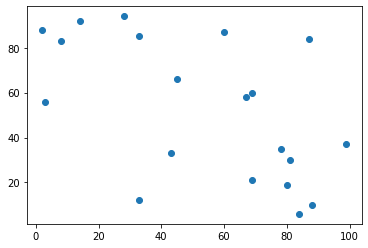

In [3]:
#@title **code** To produce city locations
w_size = 100
n_cities = 20
cities = (np.random.random((n_cities,2))*w_size).astype(int)
cities = np.array([[ 2,88],[87,84],[84,6],[99,37], [60, 87], [ 8, 83], [43, 33], [45, 66], [28, 94], [ 3, 56], [14, 92], [88, 10], [33, 12], [33, 85], [69, 60], [67, 58], [80, 19], [81, 30], [69, 21], [78, 35]])
plt.scatter(cities[:,0], cities[:,1])
def TSP_cost(cities, solution):
    sol_cities = cities[solution]
    return np.sum(np.sqrt(np.sum((sol_cities - np.roll(sol_cities,-1, axis=0))**2, axis=1)))

One example of the cities solutions by using the permutation.

In [ ]:
#@title **code**  Example of solutions
sol = np.random.permutation(len(cities))
print( sol)

# **3. SA: initialization, annealing, template**

We use the same functions that GAs for TSP in previous lecture


In [13]:
#@title **code** To initialize and plot solutions 

def TSP_initialize_population(n_individuals, n_cities):
    r = []
    for i in range(n_individuals):
        r.append(np.random.permutation(n_cities))
    return np.array(r)

def TSP_plot_solution(cities, solution):
    plt.scatter(cities[:,0], cities[:,1],s=50, c= "blue", alpha=0.6, edgecolors="black", linewidths=3 ) 
    plt.plot(cities[solution,0].tolist()+[cities[solution[0],0]], 
             cities[solution,1].tolist()+[cities[solution[0],1]])
    plt.scatter(cities[solution[0],0], cities[solution[0],1], marker="x", s=60, c="red", lw="5")
    plt.title("cost %.3f"%(TSP_cost(cities, solution)))
    
def TSP_cost(cities, solution):
    sol_cities = cities[solution]
    return np.sum(np.sqrt(np.sum((sol_cities - np.roll(sol_cities,-1, axis=0))**2, axis=1)))
    
def TSP_plot_result(best, bests, means, stds):
    fig = plt.figure(figsize=(12,4))
    fig.add_subplot(121)
    plot_evolution(bests, means, stds)
    fig.add_subplot(122)
    TSP_plot_solution(cities, best)

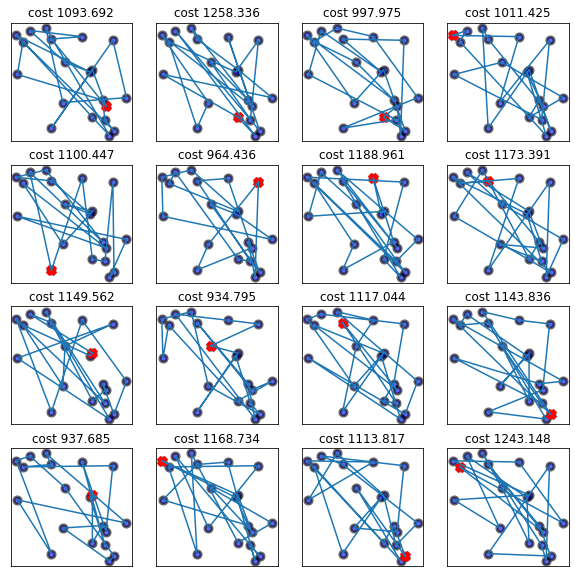

In [14]:
#@title **code** To plot solutions
fig = plt.figure(figsize=(10,10))
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    one_solution = np.random.permutation(n_cities)
    TSP_plot_solution(cities, one_solution)
    ax.set_xticks([])
    ax.set_yticks([])

## **3.2 Heating function**

The idea is to locally dispers the atoms with heat. To simulate this process we simply create a function to obtain a interchange a couple of neighbours from any solution. 

In [15]:
#@title **code** The heating function

def TSP_neighbour(solution):
    i1 = np.random.randint(len(solution))
    i2 = i1+1 if i1<len(solution)-1 else 0
    r = np.copy(solution)
    r[i1]=solution[i2]
    r[i2]=solution[i1]
    return r

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- What about next function?

In [16]:

def TSP_neighbour2(solution):
    return TSP_neighbour(TSP_neighbour(solution))

# **4. SA: Assembling (cooling) and analysing examples**

Now, we emulate the cooling process, a $\Delta_t$ function,  by doing a *set of cooling iterations* and then we **lower** the temperature. 

In [17]:
#@title **code** Simulated annealing
%%writefile code/sa.py

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

def plot_evolution(bests, means, stds):
    plt.plot(means, label="means")
    plt.plot(bests, label="bests")
    plt.fill_between(range(len(means)), means-stds, means+stds, color="yellow", alpha=0.2)
    plt.legend()

def run_sa(n_individuals, n_cooling_steps, init_population_function, cost_function, generate_neighbor_function):

    pop = init_population_function(n_individuals)

    mean_costs = []
    std_costs  = []
    best_costs = []
    best_sols  = []

    min_cost = np.inf
    min_sol  = None

    for T in tqdm(np.linspace(1,0,n_cooling_steps)):
        costs = []
        for i in range(len(pop)):
            sol = pop[i]
            cost_sol = cost_function(sol)

            # generate a neighbour
            nbr = generate_neighbor_function(sol)
            cost_nbr = cost_function(nbr)

            # if the neighbour is better
            if cost_nbr<cost_sol or np.random.random()<T:
                sol = nbr
                cost_sol = cost_nbr

            pop[i] = sol
            costs.append(cost_sol)

            if cost_sol < min_cost:
                min_sol  = np.copy(pop[i])
                min_cost = cost_function(pop[i])

        best_costs.append(np.min(costs))
        mean_costs.append(np.mean(costs))
        std_costs.append(np.std(costs))

    mean_costs = np.array(mean_costs)
    std_costs  = np.array(std_costs)
    best_costs = np.array(best_costs)
    
    return min_sol, best_costs, mean_costs, std_costs
    

Overwriting code/sa.py


### With few sample solutions and few steps for cooling

<Figure size 432x288 with 0 Axes>

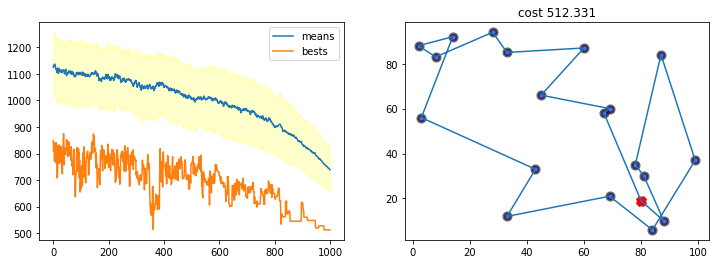

In [18]:
#@title **code** run solution 
%run code/sa.py

n_individuals = 200
n_cooling_steps = 1000


bestsol, bests, means, stds = run_sa(n_individuals              = n_individuals, 
                                     n_cooling_steps            = n_cooling_steps, 
                                     init_population_function   = lambda x: TSP_initialize_population(x, n_cities), 
                                     cost_function              = lambda x: TSP_cost(cities, x),
                                     generate_neighbor_function = TSP_neighbour2)


TSP_plot_result(bestsol, bests, means, stds)

### With few sample solutions BUT many cooling steps

<Figure size 432x288 with 0 Axes>

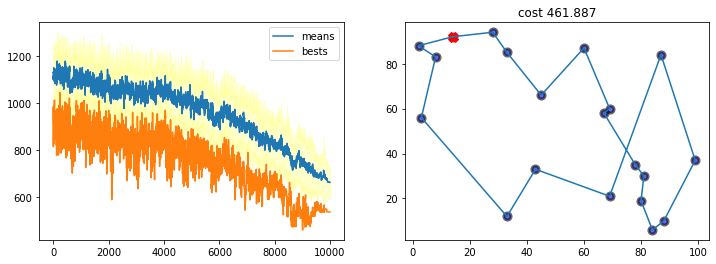

In [19]:
#@title **code** other examples
%run code/sa.py

n_individuals = 20
n_cooling_steps = 10000

bestsol, bests, means, stds = run_sa(n_individuals              = n_individuals, 
                                     n_cooling_steps            = n_cooling_steps, 
                                     init_population_function   = lambda x: TSP_initialize_population(x, n_cities), 
                                     cost_function              = lambda x: TSP_cost(cities, x),
                                     generate_neighbor_function = TSP_neighbour)


TSP_plot_result(bestsol, bests, means, stds);

<Figure size 432x288 with 0 Axes>

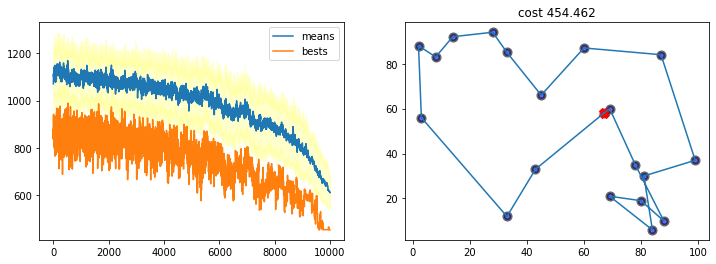

In [20]:
#@title **code** other examples
%run code/sa.py

n_individuals = 40
n_cooling_steps = 10000


bestsol, bests, means, stds = run_sa(n_individuals              = n_individuals, 
                                     n_cooling_steps            = n_cooling_steps, 
                                     init_population_function   = lambda x: TSP_initialize_population(x, n_cities), 
                                     cost_function              = lambda x: TSP_cost(cities, x),
                                     generate_neighbor_function = TSP_neighbour2)

TSP_plot_result(bestsol, bests, means, stds)

## With many sample solutions BUT no so much cooling steps
(can take several minutes...be patient!)

In [ ]:
%run ../code/sa.py

n_individuals = 1000
n_cooling_steps = 5000

bestsol, bests, means, stds = run_sa(n_individuals              = n_individuals, 
                                     n_cooling_steps            = n_cooling_steps, 
                                     init_population_function   = lambda x: TSP_initialize_population(x, n_cities), 
                                     cost_function              = lambda x: TSP_cost(cities, x),
                                     generate_neighbor_function = TSP_neighbour2)


TSP_plot_result(bestsol, bests, means, stds)

## <span style="color:orange">student</span>: 

- What about a exponential cooling?

In [ ]:
%%writefile ../code/sa2.py



In [ ]:
%run ../code/sa2.py

n_individuals = 1000
n_cooling_steps = 5000

bestsol, bests, means, stds = run_sa(n_individuals              = n_individuals, 
                                     n_cooling_steps            = n_cooling_steps, 
                                     init_population_function   = lambda x: TSP_initialize_population(x, n_cities), 
                                     cost_function              = lambda x: TSP_cost(cities, x),
                                     generate_neighbor_function = TSP_neighbour2)


TSP_plot_result(bestsol, bests, means, stds)

- Try with other heating functions. Use a mutation version from previous lecture 

In [ ]:
def TSP_mutateasHeating(solution, mutation_prob):


In [ ]:
%%writefile ../code/sa3.py


    

In [ ]:
%run ../code/sa3.py

n_individuals = 100
n_cooling_steps = 1000

bestsol, bests, means, stds = run_sa(n_individuals              = n_individuals, 
                                     n_cooling_steps            = n_cooling_steps, 
                                     init_population_function   = lambda x: TSP_initialize_population(x, n_cities), 
                                     cost_function              = lambda x: TSP_cost(cities, x),
                                     TSP_mutateasHeating        = TSP_mutateasHeating,
                                     heat_prob                  = 0.8)


TSP_plot_result(bestsol, bests, means, stds)

# References

[1] - Original paper: Kirkpatrick, S., Gelatt, C.D., and Vecchi, M.P., “Optimization by Simulated
Annealing,” Science, Volume 220, Number 4598, 13 May 1983, pp. 671- 680



---
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/bannerThanks.jpg" alt="Drawing" style="width:700px;">
